In [6]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sympy as sp
#import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma

from sympy.interactive import printing
printing.init_printing()
torch.manual_seed(101)
pyro.set_rng_seed(1)

In [63]:
# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

In [8]:
nobs = len(data)
theta = 0.6

In [9]:
data_numpy=[]
for i in data:
    data_numpy.append(i.detach().numpy())
data_numpy=np.array(data_numpy)

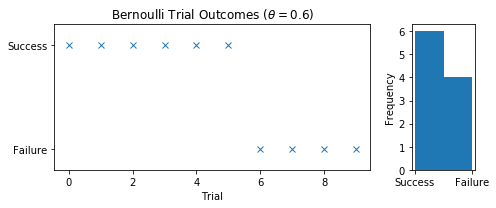

In [10]:
# Plot the data
fig = plt.figure(figsize=(7,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(range(nobs), data_numpy, 'x')
ax2.hist(-data_numpy, bins=2)

ax1.yaxis.set(ticks=(0,1), ticklabels=('Failure', 'Success'))
ax2.xaxis.set(ticks=(-1,0), ticklabels=('Success', 'Failure'));

ax1.set(title=r'Bernoulli Trial Outcomes $(\theta=0.6)$', xlabel='Trial', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')

fig.tight_layout()

# Likelihood

Consider a sample of $T$ draws from the random variable $y$. The joint likelihood of observing any specific sample $$Y = (y_1, …, y_T)’$$ is given by:

$$
\begin{align}
p(Y|\theta) & = \prod_{i=1}^T \theta^{y_i} (1-\theta)^{1-y_i} \\
& = \theta^{s} (1 - \theta)^{T-s}
\end{align} 
$$

where $s = \sum_i y_i$ is the number of observed “successes”, and $T−s$  is the number of observed “failures”.

In [ ]:
t, T, s = sp.symbols('theta, T, s')

# Create the function symbolically
likelihood = (t**s)*(1-t)**(T-s)

# Convert it to a Numpy-callable function
_likelihood = sp.lambdify((t,T,s), likelihood, modules='numpy')

# Prior

$$
p(\theta;\alpha_1,\alpha_2) = \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1}
$$

Prior mean: 0.5


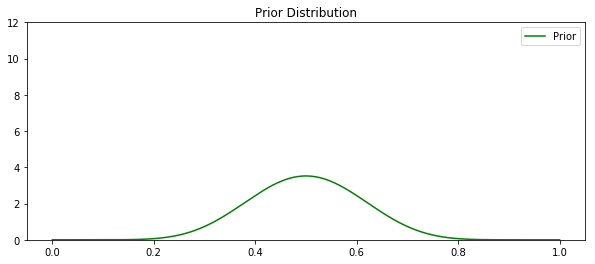

In [11]:
# Prior Mean
a1=10
a2=10
prior_mean = a1 / (a1 + a2)
print('Prior mean:', prior_mean)

# Plot the prior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');

# Cleanup\

ax.set(title='Prior Distribution', ylim=(0,12))
ax.legend(['Prior']);

# Posterior Analytical

$$
\begin{align}
p(\theta|Y;\alpha_1,\alpha_2) & = \frac{P(Y|\theta) P(\theta)}{P(Y)} \\
& \propto P(Y|\theta) P(\theta) \\
& = \theta^s (1-\theta)^{T-s} \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1} \\
& \propto \theta^{s+\alpha_1-1} (1 - \theta)^{T-s+\alpha_2 - 1} \\
\end{align}
$$

The last line is identifiable as the kernel of a beta distribution with parameters

$$
(\hat \alpha_1, \hat \alpha_2) = (s+\alpha_1, T-s+\alpha_2)
$$

Thus the posterior is given by

$$
P(\theta|Y;\alpha_1,\alpha_2) = \frac{1}{B(\hat \alpha_1, \hat \alpha_2)} \theta^{\hat \alpha_1 - 1} (1-\theta)^{\hat \alpha_2 -1}
$$

In [12]:
# Find the hyperparameters of the posterior
a1_hat = a1 + data_numpy.sum()
a2_hat = a2 + nobs - data_numpy.sum()

# Posterior Mean
post_mean = a1_hat / (a1_hat + a2_hat)
print('Posterior Mean (Analytic):', post_mean)

Posterior Mean (Analytic): 0.5333333333333333


In [127]:

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()


def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')


....................

In [14]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.529 +- 0.090


In [128]:
# Variational Distribution
Samples = 1000
q=[] 
for i in range(Samples):
    q.append(pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q)).detach().numpy())

## Samples of Joint Density Function

In [155]:
Pos = stats.beta(a1_hat,a2_hat).pdf(q)

In [ ]:
q=stats.beta(alpha_q,beta_q).pdf(q)

In [ ]:
from sklearn import metrics

In [120]:
q=stats.beta(alpha_q,beta_q).pdf(q)

In [154]:
q= [0.62244767, 0.35585815, 0.45539686, 0.5092667  ,0.5307654  ,0.57210445,
 0.49359983 ,0.58195525, 0.29873976, 0.50001144]

In [125]:
def KL(P,Q):
    epsilon = 0.00001

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log2(P/Q))
    return divergence

In [141]:
q =[0.4030483, 0.4743743,0.3402234,0.46772808,0.609517,0.53739446,0.637365,0.54865164,0.52086014,0.71507657,0.45198137,
0.5088181,
0.30521503,
0.4235325,
0.6319748,
0.63678056,
0.3884156,
0.3000593,
0.5168655,
0.37515214,
0.5933833,
0.5185674,
0.56426895,
0.5708021,
0.50559217,
0.61087704,
0.458703,
0.6056636,
0.5626066,
0.46898738,
0.48307812,
0.26114506,
0.51236653,
0.46834695,
0.49435118,
0.5633133,
0.40655282,
0.53550327,
0.68615,
0.36124444,
0.46703234,
0.53681827,
0.5483676,
0.36375684,
0.5032293,
0.45162115,
0.5557717,
0.37394562,
0.45886377,
0.6420432,
0.1987,
0.49778283,
0.7055841,
0.36285105,
0.5847408,
0.32526967,
0.35765475,
0.47098297,
0.56621283,
0.36989516,
0.68369836,
0.39806393,
0.418344,
0.4812845,
0.26590163,
0.3961185,
0.6041267,
0.47325048,
0.41345757,
0.5866645,
0.42615256,
0.5695295,
0.4498821,
0.46969238,
0.49950486,
0.45338795,
0.49447438,
0.6245716,
0.56271553,
0.47939858,
0.4243044,
0.5968154,
0.567932,
0.51435864,
0.66213876,
0.76029897,
0.3489127,
0.44312975,
0.51295644,
0.6478894,
0.55367965,
0.33584058,
0.50274163,
0.6688169,
0.2495143,
0.6432432,
0.5865521,
0.3692792,
0.5888892,
0.4838844,
0.68767613,
0.55033046,
0.6279857,
0.64363754,
0.36802465,
0.41258135,
0.3586891,
0.7089717,
0.5589471,
0.67408264,
0.388382,
0.67211676,
0.48945397,
0.47385368,
0.41359848,
0.4025819,
0.4535025,
0.31183067,
0.54102534,
0.43982068,
0.65893734,
0.40642005,
0.49217212,
0.4796276,
0.61490923,
0.29674453,
0.6248585,
0.63088274,
0.5714012,
0.5298176,
0.61511284,
0.60288715,
0.64139235,
0.45988014,
0.41673127,
0.50943774,
0.55970436,
0.5544529,
0.429082,
0.518801,
0.45964167,
0.39941457,
0.5269445,
0.57764083,
0.5495614,
0.6960615,
0.47469327,
0.47595066,
0.31568575,
0.2807171,
0.2734061,
0.56536573,
0.4334805,
0.40726405,
0.26793516,
0.39859703,
0.4074389,
0.30679742,
0.46489766,
0.39355928,
0.5557079,
0.3101899,
0.6335303,
0.40764907,
0.39297274,
0.61525005,
0.5610382,
0.64888835,
0.48805767,
0.49512333,
0.3990857,
0.26759508,
0.56720465,
0.5926925,
0.46300393,
0.3996374,
0.55945545,
0.44265085,
0.5059214,
0.51025975,
0.5325363,
0.43671232,
0.460447,
0.6680135,
0.6685691,
0.6080664,
0.37705898,
0.47939053,
0.4503471,
0.5607763,
0.60860705,
0.46038592,
0.52397317,
0.6660623,
0.42253843,
0.43376252,
0.64118356,
0.46918938,
0.45417088,
0.35480297,
0.3769578,
0.5018264,
0.3860679,
0.3035042,
0.58120376,
0.50707424,
0.5839827,
0.5938512,
0.36024317,
0.39431834,
0.40927407,
0.6100964,
0.5895368,
0.49756986,
0.39890325,
0.505655,
0.39601567,
0.5048953,
0.6552301,
0.5591606,
0.4416258,
0.6229905,
0.5249499,
0.6123623,
0.31678507,
0.33698818,
0.38344097,
0.34799075,
0.67515993,
0.5007376,
0.48419353,
0.5932752,
0.39784515,
0.62424654,
0.63514787,
0.37968642,
0.55057526,
0.51185197,
0.38830724,
0.6173137,
0.49146876,
0.4009524,
0.5966706,
0.5007717,
0.40589464,
0.36981425,
0.52686876,
0.5516117,
0.58112645,
0.55188596,
0.83647215,
0.47016898,
0.4133739,
0.3898437,
0.7614184,
0.65443045,
0.40003648,
0.47672608,
0.3820932,
0.4134137,
0.5140306,
0.5708283,
0.45006078,
0.6582079,
0.4455922,
0.33846107,
0.48233435,
0.519557,
0.5274707,
0.4837609,
0.52549815,
0.46584493,
0.52488846,
0.6121102,
0.6379669,
0.56704074,
0.46440685,
0.60320705,
0.5328727,
0.7979556,
0.3712847,
0.31992513,
0.35884076,
0.5140279,
0.51243263,
0.5838941,
0.5149347,
0.36796618,
0.4759599,
0.34545252,
0.47734845,
0.3853116,
0.40154624,
0.5793461,
0.4184534,
0.4712549,
0.49237576,
0.66599464,
0.26028338,
0.39210314,
0.29271567,
0.66383684,
0.4828629,
0.5032535,
0.44663218,
0.43075967,
0.3199271,
0.19515839,
0.7517509,
0.4794942,
0.31207532,
0.43234798,
0.48643294,
0.40296698,
0.66413313,
0.49632072,
0.52862495,
0.3248612,
0.6211145,
0.5658103,
0.5659147,
0.5722957,
0.58411014,
0.39328653,
0.44080853,
0.4859975,
0.6332268,
0.3115999,
0.4432517,
0.56524265,
0.6914607,
0.6202645,
0.4479727,
0.44964427,
0.44954005,
0.6530354,
0.49856448,
0.44026494,
0.6000368,
0.35748476,
0.5419327,
0.48003712,
0.48390573,
0.50341845,
0.44525933,
0.5921392,
0.6886868,
0.5244933,
0.58285594,
0.40575436,
0.42567885,
0.58362657,
0.6356916,
0.7111823,
0.4756701,
0.45691898,
0.71864307,
0.38198096,
0.22994225,
0.41300324,
0.45797285,
0.38422102,
0.4577148,
0.45114994,
0.37689474,
0.53207636,
0.5047774,
0.38871592,
0.3274237,
0.3136247,
0.5259556,
0.54236364,
0.5829218,
0.26759169,
0.38716856,
0.64258164,
0.32595545,
0.5300897,
0.28579518,
0.39027876,
0.4744737,
0.47318104,
0.45232284,
0.5382562,
0.5176387,
0.4923304,
0.5205062,
0.5708983,
0.5643948,
0.39938265,
0.36875787,
0.5451953,
0.53140956,
0.66698515,
0.4455389,
0.5787567,
0.43964306,
0.50954133,
0.29969028,
0.6276227,
0.3233997,
0.6515812,
0.4776547,
0.5088503,
0.5024885,
0.4581817,
0.4782022,
0.25204718,
0.38602203,
0.4241581,
0.5311422,
0.41098985,
0.585896,
0.35800034,
0.5994189,
0.6129093,
0.36515626,
0.5231648,
0.6277609,
0.57239354,
0.65765303,
0.5444694,
0.414659,
0.48224276,
0.66749644,
0.4884644,
0.35514173,
0.43140957,
0.45101094,
0.47159818,
0.30544627,
0.5027004,
0.24946812,
0.52481395,
0.6198305,
0.5606963,
0.6873359,
0.48106098,
0.48574522,
0.56582505,
0.36136854,
0.4813452,
0.61444545,
0.58394116,
0.5184439,
0.52817494,
0.32666126,
0.5516361,
0.44973692,
0.49827686,
0.5458956,
0.5077372,
0.5738879,
0.574555,
0.36873463,
0.70141447,
0.5002864,
0.62734,
0.38396376,
0.44671297,
0.36526394,
0.605399,
0.47707403,
0.58252186,
0.5792243,
0.52452123,
0.46837956,
0.46586013,
0.42696327,
0.6375551,
0.6322468,
0.45622256,
0.34422386,
0.3600932,
0.5746645,
0.49548998,
0.61221445,
0.40375873,
0.5964296,
0.38815966,
0.49418205,
0.5084736,
0.5020307,
0.4242126,
0.54080194,
0.38734156,
0.42452255,
0.6600196,
0.4383256,
0.5661695,
0.6006368,
0.55961484,
0.5679763,
0.38563156,
0.50376564,
0.45854872,
0.5070752,
0.564475,
0.45194805,
0.68071103,
0.49124908,
0.4879976,
0.39712247,
0.51102996,
0.59143513,
0.48882532,
0.6048416,
0.647148,
0.38782403,
0.39636257,
0.49110493,
0.53052276,
0.42836186,
0.55594665,
0.6093204,
0.4741958,
0.6304581,
0.5927683,
0.5564896,
0.38589975,
0.54241484,
0.55793047,
0.3544578,
0.31516102,
0.23791021,
0.4013195,
0.5951722,
0.5326213,
0.5390856,
0.6286703,
0.49282998,
0.5388889,
0.51963794,
0.45776585,
0.5976338,
0.5920074,
0.38454077,
0.5653985,
0.5524531,
0.55454576,
0.36336562,
0.40001848,
0.5591271,
0.2899428,
0.5343195,
0.48668256,
0.40844074,
0.5011,
0.61532325,
0.7406221,
0.69315714,
0.39989504,
0.49484763,
0.50960374,
0.3767531,
0.44439027,
0.60014576,
0.48233142,
0.3888543,
0.52820176,
0.38630146,
0.5173651,
0.40142828,
0.37359738,
0.42310843,
0.42003575,
0.6723627,
0.45710233,
0.4494261,
0.58080894,
0.5590546,
0.5407674,
0.4193292,
0.44031626,
0.52442193,
0.6555675,
0.48636034,
0.47417498,
0.3997109,
0.4491307,
0.5461978,
0.47470134,
0.43915436,
0.70005715,
0.34331784,
0.38849825,
0.573675,
0.25498888,
0.5294818,
0.45434937,
0.4539832,
0.51202595,
0.52840716,
0.38444728,
0.3467391,
0.71947515,
0.35414284,
0.4767237,
0.41015127,
0.32926723,
0.51589763,
0.4804485,
0.47848,
0.63261247,
0.3098561,
0.4707266,
0.65477765,
0.59457433,
0.3522551,
0.43794233,
0.648772,
0.5429041,
0.4963358,
0.6992292,
0.5903052,
0.6347885,
0.3827954,
0.52913404,
0.43300846,
0.4890121,
0.5201063,
0.37112626,
0.32771036,
0.36483988,
0.46065968,
0.4973884,
0.27277267,
0.5170219,
0.4628762,
0.47330278,
0.48023048,
0.41893348,
0.5310829,
0.68571377,
0.46446934,
0.531483,
0.49241704,
0.4175054,
0.5377278,
0.37541986,
0.2893488,
0.43711373,
0.66031015,
0.585445,
0.40739465,
0.48850274,
0.52395827,
0.40957433,
0.56923646,
0.4642217,
0.4591674,
0.6048874,
0.336486,
0.40172005,
0.6899629,
0.5511085,
0.3880428,
0.6168329,
0.4262205,
0.46486235,
0.5056739,
0.505817,
0.48756126,
0.5297398,
0.4428588,
0.4206092,
0.44816288,
0.34737912,
0.6294244,
0.38391772,
0.4251355,
   0.5856435,
0.4548536,
0.6931503,
0.56473464,
0.65965,
0.42914653,
0.58789444,
0.659074,
0.4667196,
0.4594525,
0.5079579,
0.4456277,
0.49763873,
0.5513197,
0.5092283,
0.44542652,
0.4101937,
0.5067923,
0.4954692,
0.39733863,
0.5102642,
0.49670297,
0.5366017,
0.47668976,
0.59040153,
0.49645492,
0.6061471,
0.6532366,
0.2981545,
0.623241,
0.47766536,
0.52440894,
0.7213083,
0.26850733,
0.5457751,
0.6322124,
0.5640596,
0.28425893,
0.29798812,
0.37662175,
0.3521087,
0.47664893,
0.32259172,
0.6330259,
0.42887712,
0.50908375,
0.44287002,
0.7039622,
0.51323694,
0.41990802,
0.5888445,
0.57601637,
0.47314605,
0.4282304,
0.5468587,
0.6480338,
0.39839432,
0.57501006,
0.57272863,
0.44966766,
0.44642258,
0.53160083,
0.5041579,
0.50603855,
0.39215207,
0.6079849,
0.39066112,
0.59342945,
0.34189653,
0.47709846,
0.7729596,
0.301086,
0.4951376,
0.57142246,
0.5831612,
0.55307424,
0.73273724,
0.4626772,
0.55044466,
0.40610918,
0.5679439,
0.51553303,
0.37025592,
0.44463477,
0.5373631,
0.46983558,
0.6198054,
0.5272889,
0.40497184,
0.74327725,
0.727283,
0.6500348,
0.45481592,
0.5582277,
0.49679345,
0.5279441,
0.5630818,
0.7107524,
0.56259555,
0.6645513,
0.53064716,
0.35329705,
0.32606077,
0.3920462,
0.64359695,
0.683955,
0.5745398,
0.4722275,
0.3936011,
0.49557996,
0.42123505,
0.48848763,
0.4472094,
0.6521686,
0.633172,
0.44353402,
0.50363976,
0.62773466,
0.4934763,
0.35276967,
0.63379276,
0.5802173,
0.5993094,
0.41228518,
0.47288832,
0.34558636,
0.5522198,
0.29619777,
0.37681735,
0.60724276,
0.42901984,
0.46018696,
0.58662605,
0.62581617,
0.45588183,
0.5421164,
0.5213981,
0.60560226,
0.69748926,
0.5585762,
0.5699758,
0.42819312,
0.33982977,
0.47892517,
0.3549038,
0.3724584,
0.4486875,
0.29173255,
0.45402202,
0.725503,
0.5744549,
0.44146746,
0.5645185,
0.5908494,
0.5979034,
0.69535106,
0.48128223,
0.6250761,
0.57119375,
0.38916102,
0.3835855,
0.52074504,
0.68473744,
0.46387357,
   0.47702384,
0.53647,
0.5750575,
0.47426426,
0.57313937,
0.39234206,
0.6288842,
0.5252689,
0.38850424,
0.3680866,
0.47277272,
0.5416357,
0.4358402,
0.3494435,
0.6573469,
0.50853986,
0.4605494,
0.49259144,
0.52275306,
0.3606655,
0.56360817,
0.5242543,
0.525783,
0.3110732,
0.49098143,
0.46418655,
0.5700129,
0.5436768,
0.6514052,
0.6015511,
0.39417592,
0.40583456,
0.4134968,
0.42945036,
0.5471318,
0.46784228,
0.5263234,
0.6148443,
0.49174255,
0.45607153,
0.4972453,
0.51227003,
0.35908478,
0.5237749,
0.39642343,
0.43072993,
0.29905757,
0.4849376,
0.3798477,
0.40077832,
0.5660095,
0.64282286,
0.5813347,
0.6742436,
0.45631668,
0.42580372,
0.6397633,
0.6057655,
0.47660002,
0.60123104,
0.5609503,
0.45668373,
0.41404983,
0.46079606,
0.3674267,
0.36714983,
0.5411009,
0.6857464,
0.43443406,
0.36702538,
0.40412953,
0.44029754,
0.50276047,
0.57385737,
0.5347364,
0.5731814,
0.5123194,
0.6482125,
0.64284635,
0.45940226,
0.5071227,
0.5316123,
0.3620508,
0.618221,
0.5542364,
0.3526345,
0.3044835,
0.62280935,
0.45919165,
0.314894,
0.5546203,
0.4457449,
0.4902404,
0.4624071,
0.5549925,
0.5662385,
0.4250465,
0.535592,
0.50995624,
0.65965337,
0.3708526,
0.38512102,
0.25416702,
0.58974797,
0.30421725,
0.3220606,
0.52695864,
0.62583435,
0.5295545,
0.4212043,
0.50413966,
0.39268687,
0.5976003,
0.642323,
0.5532844,
0.3355469,
0.6660799,
0.3596624,
0.55134255,
0.41203764,
0.49245048,
0.53203875,
0.57501954,
0.2991423,
0.6441661,
0.44826543,
0.39071658,
0.535284,
0.55224514,
0.53616077,
0.502055,
0.42536196,
0.47372743,
0.36617833,
0.67477083,
0.45589763,
0.49774548,
0.37047386,
0.42405558,
0.3805792,
0.704926,
0.34164497,
0.51831865,
0.3864112,
0.63192034,
0.37039086,
0.58070785,
0.5395089,
0.478646,
0.5490661,
0.3659447,
0.5468666,
0.5194541,
0.4744367,
0.72759634,
0.6834577,
0.32722193,
0.46512178,
0.3517224,
0.5409232,
0.57207143,
0.5438398,
0.5269885,
0.4784372,
0.55699146]

In [148]:
q = np.array(q)

In [161]:
86.44232120675083-11.942404155295446

In [157]:
KL(np.array(Pos),np.array(q))

In [158]:
KL(np.array(q),np.array(Pos))

In [151]:
(KL(Pos,q)+KL(q,Pos))/2

In [167]:
Ratio = []
ind = 0
for i in Pos:
    Ratio.append(np.log(i/q[ind]))
    ind+=1

In [117]:
0.09457788 0.29024988 0.6222678  0.5485139  0.5746509  0.76110834
 0.76081175 0.53403896 0.42990243 0.7214984

NameError: name 'a_hat' is not defined

In [170]:
Ratio

In [171]:
print(psisloo(np.array(Ratio)))
print('K:'+str(psisloo(1*np.array(Ratio))[2]))

(0.9795396776401544, 0.9795396776401544, inf)
K:inf


In [166]:
neg_log = [] # To Test if the log weights need to be negative for the psislw function
for i in Ratio:
    i=i*-1
    neg_log.append(i)

In [ ]:
#psislw(np.array(neg_log)) # Indeed this function takes in negative logweights. 

In [ ]:
#psislw(np.array(Ratio)) # Without negative weights.

In [ ]:
# Plot the analytic posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');
#ax.plot(X, stats.beta(alpha_q, beta_q).pdf(X), 'y');

# Plot the prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');
ax.plot(X, stats.beta(alpha_q, beta_q).pdf(X), 'y--');
plt.grid()
# Cleanup
ax.set(title='Distributions', ylim=(0,5))
ax.legend(['Posterior (Analytic)', 'Prior','Variational Distribution']);

In [20]:
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc import MCMC

In [66]:
def model2(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(15.0)
    beta0 = torch.tensor(15.0)
    # sample f from the beta prior
    
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    #X.append(pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i]))
    vec=[]
    for i in range(len(data)):
        vec.append(pyro.sample("obs_{}".format(i), dist.Bernoulli(logits=(f)), obs=data[i]).detach().numpy().flatten())
    return torch.tensor(vec).float()

In [93]:
def model(data):
    coefs_mean = torch.zeros(len(data))
    coefs = pyro.sample("latent_fairness", dist.Beta(10, 10))
    y = torch.tensor(pyro.sample('y', dist.Bernoulli(logits=(coefs)), obs=data)).float()
    return y

In [114]:
data = torch.tensor([1.0] * 6 + [0.0] * 4)  # using Pyro 0.2 syntax
#data = Variable(torch.Tensor([1] * 6 + [0] * 4))  # in Pyro 0.1 syntax

def model(data):
    # observe all data at once
    alpha0 = torch.autograd.Variable(torch.Tensor([10.0]))
    beta0 = torch.autograd.Variable(torch.Tensor([10.0]))
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    with pyro.iarange("data", len(data)):
        X = pyro.sample("obs",
                    dist.Bernoulli(f).expand_by(data.shape).independent(1),
                    obs=data)
    return X.float()

In [116]:
data

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.])

In [115]:
hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
mcmc_run = MCMC(hmc_kernel, num_samples=500, warmup_steps=100).run(data)
posterior = EmpiricalMarginal(mcmc_run)

AttributeError: '_Subsample' object has no attribute 'support'

In [67]:
hmc_kernel = HMC(model2, step_size=0.005, num_steps=5,adapt_step_size=True)
mcmc_run = MCMC(hmc_kernel, num_samples=5, warmup_steps=100).run(data)

In [70]:
posterior = pyro.infer.abstract_infer.EmpiricalMarginal(mcmc_run)

In [72]:
posterior.mean

tensor([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]])

In [165]:
infered_mean = np.average(np.array(posterior.mean))
print(infered_mean)

0.6


In [ ]:
infered_std = np.sqrt(np.array(posterior.mean.var()))
print(infered_std)

In [123]:

pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.autograd.Variable(torch.ones(1)))
for _ in range(4):
    data.append(torch.autograd.Variable(torch.zeros(1)))


def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.autograd.Variable(torch.Tensor([10.0]))
    beta0 = torch.autograd.Variable(torch.Tensor([10.0]))
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.beta, alpha0, beta0)
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        X=pyro.observe("obs_{}".format(i), dist.bernoulli, data[i], f)
    return G

In [ ]:
true_coefs = torch.tensor([1., 2., 3.])
dim = 3
labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()

def model(data):
    coefs_mean = torch.zeros(dim)
    coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(3)))
    y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)
    return y

hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
mcmc_run = MCMC(hmc_kernel, num_samples=500, warmup_steps=100).run(data)
posterior = EmpiricalMarginal(mcmc_run, 'beta')
posterior.mean  

In [164]:
def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.

    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).

    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).

    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.

    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces

    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    #print('Ks'+str(ks))
    return loo, loos, ks

def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).

    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.

    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``

    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.

    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices

    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)
    #print(kss)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k
        #print(k)

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss

def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.

    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.

    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out
def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)

    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.

    Parameters
    ----------
    x : ndarray
        One dimensional data array

    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.

    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).

    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.

    Returns
    -------
    k, sigma : float
        estimated parameter values

    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.

    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.

    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        #print('K:'+str(k))
        return k, sigma, ks, w
    else:
        #print('K:'+str(k))
        return k, sigma

def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x

In [2]:
import edward as ed
import tensorflow as tf
import numpy as np
from edward.models import Normal, Empirical,Beta,Bernoulli

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
p = Beta(10., 10.)
x = Bernoulli(probs=p, sample_shape=10)

In [4]:
# INFERENCE
qp = Empirical(params=tf.get_variable("qp/params", [1000], initializer=tf.constant_initializer(0.5)))
proposal_p = Beta(3.0, 9.0)
inference = ed.MetropolisHastings({p: qp}, {p: proposal_p}, data={x: data_numpy})
inference.run()



#rint("====  ed.HMC inference ====")
#rint("E[mu] = %f" % (hq_mu.params.eval()[burn:].mean()))
#rint("E[logtau] = %f" % (hq_logtau.params.eval()[burn:].mean()))
#print("E[theta_prime]=")
#print(hq_theta_prime.params.eval()[burn:, ].mean(0))
#print("====  end ed.HMC inference ====")
#print("")
#print("")


NameError: name 'data_numpy' is not defined

In [ ]:
sess = ed.get_session()
mean, stddev = sess.run([qp.mean(), qp.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev:")
print(stddev)

In [ ]:
x_post = ed.copy(x, {p: qp})

In [ ]:
tx_rep, tx = ed.ppc(lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)),data={x_post: data_numpy})
ed.ppc_stat_hist_plot(tx[0], tx_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()